# Maksymilian Wojnar

# Sudoku

In [1]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint, choice

np.random.seed(123)

## Testowe plansze Sudoku

46 przykładowych plików z planszami Sudoku pobrałem ze strony http://lipas.uwasa.fi/~timan/sudoku/. 

## Implementacja metody symulowanego wyżarzania

Funkcja wypisująca rozwiązanie oraz błąd:

In [3]:
def print_sudoku(sudoku, error):
    if error == 0:
        print(f"{'Solved':^25}")
    else:
        print(f"{'Error = ' + str(error):^25}")

    for i, line in enumerate(sudoku):
        if i % 3 == 0:
            print(f"{'-' * 25}")

        for j, val in enumerate(line):
            if j % 3 == 0:
                print("|", end=" ")

            print(int(sudoku[i, j]), end=" ")

        print("|")

    print(f"{'-' * 25}\n")

Funkcja wczytująca z pliku o nazwie "file_name" planszę sudoku oraz wypełniająca ją wartościami. Po wczytaniu danych z pliku, wypełniam tablicę w taki sposób, aby w wolnych komórkach znalazły się losowe wartości, jednak aby zachowana została zasada, iż w blokach 3x3 znajdują się wszystkie cyfry od 1 do 9. Innymi słowy, wypełniam plaszę w taki sposób, aby zapewnić, że jedna z zasad jest spełniona już na wstępie.

In [4]:
def read_and_fill(file_name):
    sudoku = np.zeros((9, 9), dtype=np.int32) # tablica z cyframi
    free_fields = [[] for _ in range(9)]      # indeksy pól, które wolno modyfikować

    with open(file_name) as file:
        text = file.read()
        
        # wypełnienie tablicy znanymi wartościami (lub 0, gdy pole jest puste)
        for i, line in enumerate(text.rstrip().split('\n')):
            for j, num in enumerate(line.rstrip().split(' ')):
                sudoku[i, j] = int(num) if num != 'x' else 0 

        counter = 0
        for i, j in product(range(0, 9, 3), range(0, 9, 3)):
            # wyszukanie liczb, które można wpisać w puste pola w danym bloku 3x3
            numbers = [i for i in range(1, 10)]
            for k, l in product(range(3), range(3)):
                if sudoku[i + k, j + l] != 0:
                    numbers.remove(sudoku[i + k, j + l])

            # wpisanie losowych wartości z listy dostępnych cyfr
            np.random.shuffle(numbers)
            for k, l in product(range(3), range(3)):
                if sudoku[i + k, j + l] == 0:
                    sudoku[i + k, j + l] = numbers.pop()
                    free_fields[counter].append([i + k, j + l])

            free_fields[counter] = np.array(free_fields[counter])
            counter += 1

    return sudoku, free_fields

Obliczanie temperatury początkowej polega na wyznaczeniu odchylenia standardowego z kilku próbek funkcji kosztu (energii) kolejnych stanów. Opieram się tutaj na pracy Rhyd'a Lewis'a "Metaheuristics can Solve Sudoku Puzzles" (http://rhydlewis.eu/papers/META_CAN_SOLVE_SUDOKU.pdf), który zaproponował to rozwiązanie.

In [5]:
def calculate_temp(sudoku_copy, free_fields):
    errors = np.zeros(10)
    sudoku = sudoku_copy.copy()

    for i in range(10):
        cell = randint(0, 8)
        l = len(free_fields[cell])
        x, y = free_fields[cell][choice(l)], free_fields[cell][choice(l)]
        sudoku[x[0], x[1]], sudoku[y[0], y[1]] = sudoku[y[0], y[1]], sudoku[x[0], x[1]]

        errors[i] = energy(sudoku)

    return np.std(errors).item()

Energia jest wyliczana jako suma powtórzeń cyfr występujących w wierszach bloku 9×9, kolumnach bloku 9×9 oraz blokach 3×3. Ponieważ podczas wczytywania planszy z pliku oraz generowania stanów sąsiednich zapewniam spełnienie ostatniego warunku, wystarczy, że ograniczę się do sumy powtórzeń w wierszach i kolumnach (suma w blokach 3x3 zawsze będzie wynosić 0).

In [6]:
def energy(sudoku):
    rows = sum([9 - len(set(sudoku[i, :])) for i in range(9)])
    cols = sum([9 - len(set(sudoku[:, i])) for i in range(9)])
    return cols + rows

Generacja stanu sąsiedniego polega na wylosowaniu jednego z bloków, a następnie na wybraniu dwóch różnych komórek, których modyfikacja jest dozwolona i zamianie ich wartości. W ten sposób zapewniam, że zasada o cyfrach w blokach 3x3 jest zawsze spełniona.

In [7]:
def random_swap(free_fields):
    field = randint(0, 9)
    cell1 = cell2 = randint(0, len(free_fields[field]))

    while cell1 == cell2:
        cell2 = randint(0, len(free_fields[field]))

    return free_fields[field][cell1], free_fields[field][cell2]

Funkcja realizująca homogeniczne symulowane wyżarzanie (dla każdej wartości temperatury, generuję $n$ przejść):

In [8]:
def anneal(sudoku, free_fields):
    # obliczenie temperatury początkowej
    t = calculate_temp(sudoku, free_fields)
    # liczba kroków dopasowana do sugestii Rhyd'a Lewis'a w "Metaheuristics can Solve Sudoku Puzzles"
    step = sum(len(field) for field in free_fields) ** 2 // 3
    # zmienna używana przy restartach
    last_improvement = 0

    # zapis najlepszego wyniku
    best_val = last = last_step = energy(sudoku)
    best_sol = sudoku.copy()
    # zapis wartości funkcji błędu
    values = [last]

    while t > 0.00001:
        for _ in range(step):
            # przejście do sąsiedniego stanu
            x, y = random_swap(free_fields)
            sudoku[x[0], x[1]], sudoku[y[0], y[1]] = sudoku[y[0], y[1]], sudoku[x[0], x[1]]
            # obliczenie nowej wartości funkcji kosztu
            new_energy = energy(sudoku)

            if new_energy < last or np.exp((last - new_energy) / t) > np.random.random():
                # przyjęcie nowej wartości, gdy jest lepsza lub z pewnym␣,→prawdopodobieństwem, gdy jest gorsza
                values.append(new_energy)
                last = new_energy

                if new_energy < best_val:
                    # uaktualnienie najlepszej wartości
                    best_val = new_energy
                    best_sol = sudoku.copy()

                if new_energy == 0:
                    # sudoku rozwiązane
                    return best_sol, values
            else:
                # przywrócenie poprzedniego stanu
                values.append(last)
                sudoku[x[0], x[1]], sudoku[y[0], y[1]] = sudoku[y[0], y[1]], sudoku[x[0], x[1]]

        # wykładniczy spadek temperatury z dobraną stałą
        t *= 0.975

        if last_step <= best_val:
            # jeśli przez 100 cykli wynik nie poprawił się, uruchamiam wyżarzanie ponownie
            last_improvement += 1
            if last_improvement >= 100:
                return best_sol, values
        else:
            last_improvement = 0

        last_step = best_val

    # zwrócenie najlepszego wyniku
    return best_sol, values

Właściwa funkcja z obsługą restartów:

In [9]:
def multiple_anneal(file_name):
    all_values = []  # zapis wszystkich wartości funkcji energii
    best_sol = None  # zapis najlepszego rozwiąznia

    # dopuszczam maksymalnie 15 restartów
    for _ in range(15):
        sudoku, free_fields = read_and_fill(file_name)
        sol, values = anneal(sudoku, free_fields)
        all_values.extend(values)

        if energy(sol) == 0:
            return sol, all_values

        if best_sol is None or energy(best_sol) > energy(sol):
            best_sol = sol
            
    return best_sol, all_values

Funkcja obliczająca ilość pustych miejsc na planszy w zadanym pliku:

In [10]:
def empty_cells(file_name):
    with open(file_name) as file:
        text = file.read()
        return sum(1 for char in text if char == '0' or char == 'x')

## Przybliżone rozwiązanie Sudoku

Dla każdej z pobranych plansz uruchamiam symulowane wyżarzanie z restartami. Na wykresie prezentuję przebieg funkcji kosztu w zależności od numeru iteracji, a poniżej rozwiązanie sugerowane przez program wraz z popełnionym błędem.

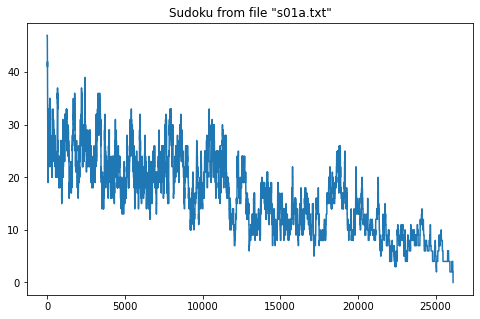

         Solved          
-------------------------
| 8 4 5 | 6 3 2 | 1 7 9 |
| 7 3 2 | 9 1 8 | 6 5 4 |
| 1 9 6 | 7 4 5 | 3 2 8 |
-------------------------
| 6 8 3 | 5 7 4 | 9 1 2 |
| 4 5 7 | 2 9 1 | 8 3 6 |
| 2 1 9 | 8 6 3 | 5 4 7 |
-------------------------
| 3 6 1 | 4 2 9 | 7 8 5 |
| 5 7 4 | 1 8 6 | 2 9 3 |
| 9 2 8 | 3 5 7 | 4 6 1 |
-------------------------



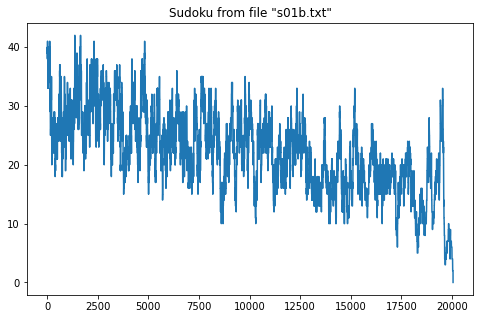

         Solved          
-------------------------
| 8 3 2 | 4 5 6 | 7 9 1 |
| 9 5 7 | 1 8 2 | 4 6 3 |
| 4 1 6 | 9 7 3 | 2 5 8 |
-------------------------
| 6 7 9 | 5 4 1 | 8 3 2 |
| 5 2 3 | 7 6 8 | 1 4 9 |
| 1 8 4 | 3 2 9 | 5 7 6 |
-------------------------
| 7 6 1 | 8 3 4 | 9 2 5 |
| 2 9 5 | 6 1 7 | 3 8 4 |
| 3 4 8 | 2 9 5 | 6 1 7 |
-------------------------



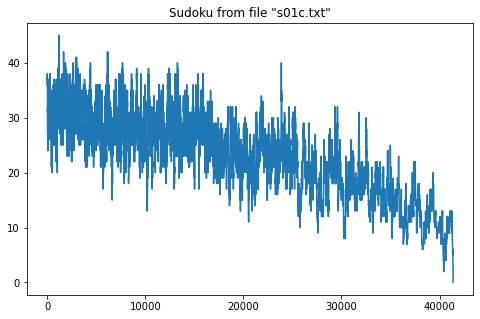

         Solved          
-------------------------
| 4 9 5 | 6 1 8 | 2 3 7 |
| 7 2 6 | 3 4 9 | 5 8 1 |
| 3 1 8 | 7 2 5 | 4 6 9 |
-------------------------
| 5 7 2 | 8 9 4 | 3 1 6 |
| 6 4 3 | 5 7 1 | 8 9 2 |
| 1 8 9 | 2 6 3 | 7 4 5 |
-------------------------
| 8 3 7 | 9 5 6 | 1 2 4 |
| 2 6 4 | 1 8 7 | 9 5 3 |
| 9 5 1 | 4 3 2 | 6 7 8 |
-------------------------



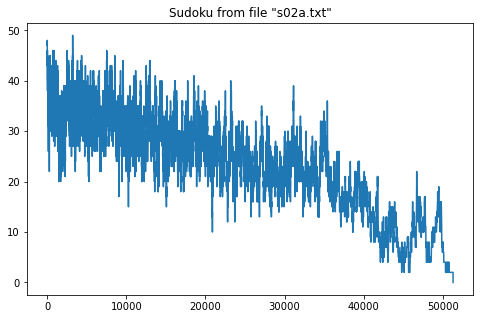

         Solved          
-------------------------
| 2 5 6 | 8 3 1 | 7 4 9 |
| 8 3 7 | 6 4 9 | 5 1 2 |
| 1 9 4 | 7 2 5 | 3 8 6 |
-------------------------
| 6 4 1 | 5 8 7 | 9 2 3 |
| 7 2 5 | 1 9 3 | 8 6 4 |
| 3 8 9 | 4 6 2 | 1 7 5 |
-------------------------
| 9 7 8 | 2 5 4 | 6 3 1 |
| 5 6 2 | 3 1 8 | 4 9 7 |
| 4 1 3 | 9 7 6 | 2 5 8 |
-------------------------



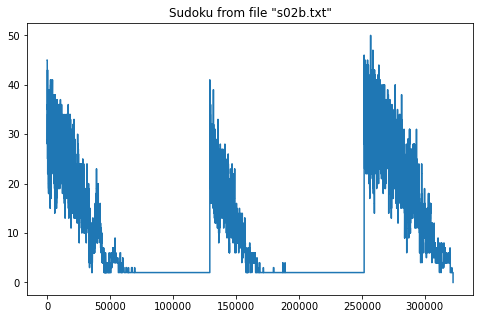

         Solved          
-------------------------
| 3 2 5 | 8 6 7 | 1 9 4 |
| 6 8 1 | 4 9 5 | 3 2 7 |
| 7 9 4 | 3 2 1 | 5 6 8 |
-------------------------
| 5 3 9 | 6 1 4 | 8 7 2 |
| 2 6 8 | 7 3 9 | 4 5 1 |
| 4 1 7 | 5 8 2 | 6 3 9 |
-------------------------
| 1 5 3 | 9 7 8 | 2 4 6 |
| 9 4 2 | 1 5 6 | 7 8 3 |
| 8 7 6 | 2 4 3 | 9 1 5 |
-------------------------



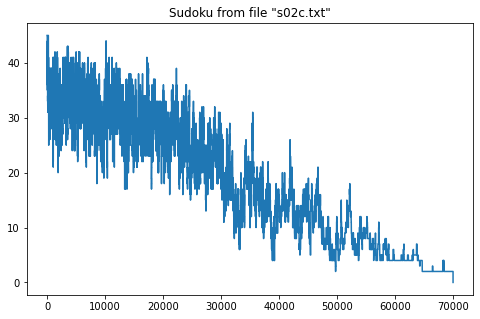

         Solved          
-------------------------
| 3 6 1 | 7 2 5 | 9 4 8 |
| 9 8 7 | 4 1 3 | 2 5 6 |
| 2 5 4 | 8 6 9 | 1 3 7 |
-------------------------
| 8 7 6 | 9 3 4 | 5 1 2 |
| 5 2 3 | 1 8 6 | 7 9 4 |
| 4 1 9 | 2 5 7 | 6 8 3 |
-------------------------
| 6 4 5 | 3 7 1 | 8 2 9 |
| 7 3 8 | 5 9 2 | 4 6 1 |
| 1 9 2 | 6 4 8 | 3 7 5 |
-------------------------



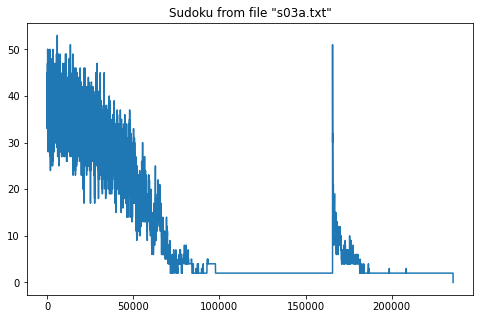

         Solved          
-------------------------
| 8 5 7 | 2 6 1 | 3 9 4 |
| 3 1 2 | 4 9 5 | 7 8 6 |
| 9 6 4 | 3 7 8 | 2 1 5 |
-------------------------
| 1 9 5 | 7 3 4 | 6 2 8 |
| 7 2 8 | 9 5 6 | 1 4 3 |
| 6 4 3 | 1 8 2 | 5 7 9 |
-------------------------
| 5 8 1 | 6 4 7 | 9 3 2 |
| 4 7 9 | 5 2 3 | 8 6 1 |
| 2 3 6 | 8 1 9 | 4 5 7 |
-------------------------



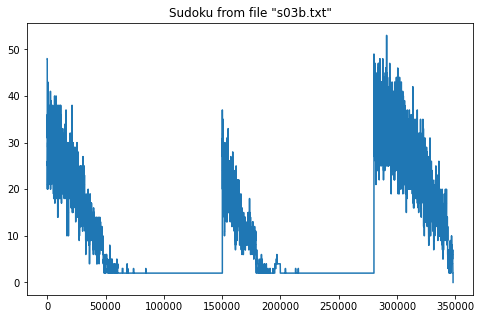

         Solved          
-------------------------
| 8 9 3 | 2 7 5 | 1 4 6 |
| 6 5 7 | 9 4 1 | 3 2 8 |
| 1 4 2 | 6 3 8 | 5 9 7 |
-------------------------
| 9 7 1 | 5 8 4 | 6 3 2 |
| 4 6 8 | 3 2 9 | 7 5 1 |
| 3 2 5 | 1 6 7 | 9 8 4 |
-------------------------
| 5 3 6 | 4 1 2 | 8 7 9 |
| 7 1 4 | 8 9 3 | 2 6 5 |
| 2 8 9 | 7 5 6 | 4 1 3 |
-------------------------



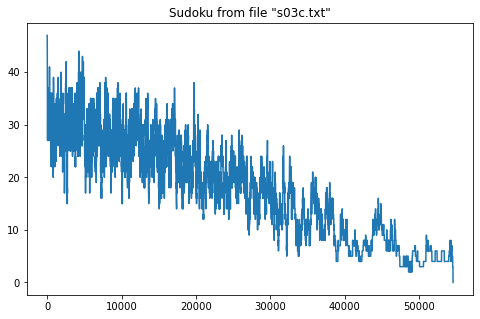

         Solved          
-------------------------
| 3 6 1 | 7 2 5 | 9 4 8 |
| 9 8 7 | 4 1 3 | 2 5 6 |
| 2 5 4 | 8 6 9 | 1 3 7 |
-------------------------
| 8 7 6 | 9 3 4 | 5 1 2 |
| 5 2 3 | 1 8 6 | 7 9 4 |
| 4 1 9 | 2 5 7 | 6 8 3 |
-------------------------
| 6 4 5 | 3 7 1 | 8 2 9 |
| 7 3 8 | 5 9 2 | 4 6 1 |
| 1 9 2 | 6 4 8 | 3 7 5 |
-------------------------



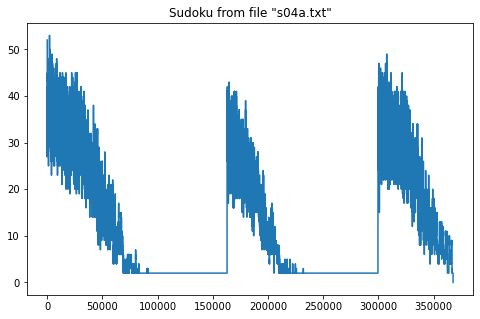

         Solved          
-------------------------
| 8 5 7 | 3 9 2 | 4 1 6 |
| 2 1 4 | 8 5 6 | 3 7 9 |
| 9 3 6 | 1 4 7 | 2 8 5 |
-------------------------
| 5 6 8 | 4 2 9 | 1 3 7 |
| 4 9 2 | 7 3 1 | 6 5 8 |
| 1 7 3 | 6 8 5 | 9 4 2 |
-------------------------
| 3 2 1 | 5 6 8 | 7 9 4 |
| 6 4 5 | 9 7 3 | 8 2 1 |
| 7 8 9 | 2 1 4 | 5 6 3 |
-------------------------



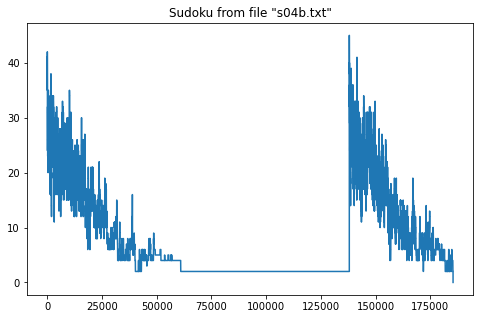

         Solved          
-------------------------
| 3 5 9 | 4 8 1 | 7 6 2 |
| 7 6 4 | 9 2 3 | 8 5 1 |
| 1 2 8 | 5 6 7 | 3 4 9 |
-------------------------
| 2 1 5 | 6 7 8 | 4 9 3 |
| 4 7 3 | 2 5 9 | 1 8 6 |
| 8 9 6 | 1 3 4 | 2 7 5 |
-------------------------
| 9 4 2 | 7 1 6 | 5 3 8 |
| 6 8 1 | 3 4 5 | 9 2 7 |
| 5 3 7 | 8 9 2 | 6 1 4 |
-------------------------



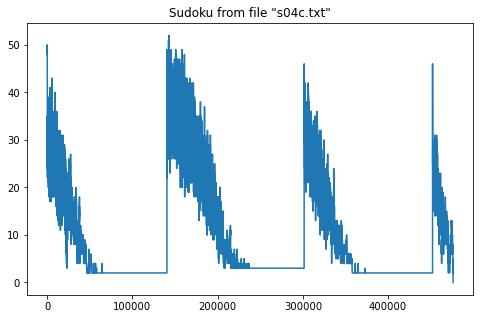

         Solved          
-------------------------
| 1 7 2 | 8 5 4 | 3 9 6 |
| 4 6 8 | 1 9 3 | 2 7 5 |
| 5 3 9 | 7 2 6 | 4 8 1 |
-------------------------
| 9 1 4 | 6 7 2 | 8 5 3 |
| 6 5 7 | 3 8 9 | 1 2 4 |
| 8 2 3 | 4 1 5 | 7 6 9 |
-------------------------
| 3 8 5 | 2 6 1 | 9 4 7 |
| 2 4 6 | 9 3 7 | 5 1 8 |
| 7 9 1 | 5 4 8 | 6 3 2 |
-------------------------



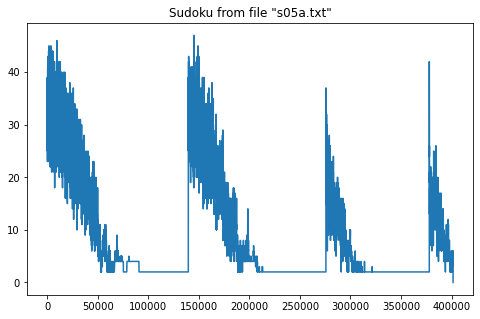

         Solved          
-------------------------
| 1 2 5 | 6 4 9 | 3 7 8 |
| 8 3 4 | 7 1 5 | 2 9 6 |
| 6 9 7 | 3 8 2 | 4 1 5 |
-------------------------
| 7 4 6 | 9 5 3 | 1 8 2 |
| 3 5 9 | 8 2 1 | 7 6 4 |
| 2 8 1 | 4 7 6 | 9 5 3 |
-------------------------
| 5 7 3 | 2 9 8 | 6 4 1 |
| 4 6 8 | 1 3 7 | 5 2 9 |
| 9 1 2 | 5 6 4 | 8 3 7 |
-------------------------



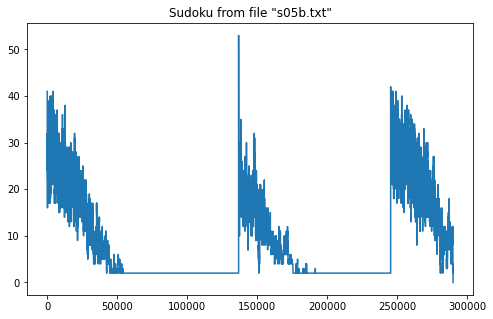

         Solved          
-------------------------
| 8 4 1 | 3 6 5 | 7 9 2 |
| 7 3 6 | 2 9 4 | 8 1 5 |
| 5 2 9 | 1 8 7 | 6 3 4 |
-------------------------
| 2 8 5 | 6 7 1 | 3 4 9 |
| 6 9 7 | 4 3 2 | 1 5 8 |
| 4 1 3 | 8 5 9 | 2 6 7 |
-------------------------
| 1 7 2 | 5 4 3 | 9 8 6 |
| 3 5 8 | 9 2 6 | 4 7 1 |
| 9 6 4 | 7 1 8 | 5 2 3 |
-------------------------



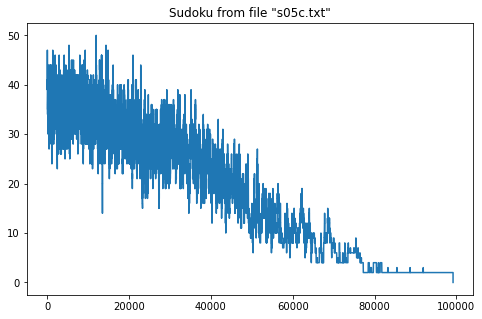

         Solved          
-------------------------
| 3 6 1 | 7 2 5 | 9 4 8 |
| 9 8 7 | 4 1 3 | 2 5 6 |
| 2 5 4 | 8 6 9 | 1 3 7 |
-------------------------
| 8 7 6 | 9 3 4 | 5 1 2 |
| 5 2 3 | 1 8 6 | 7 9 4 |
| 4 1 9 | 2 5 7 | 6 8 3 |
-------------------------
| 6 4 5 | 3 7 1 | 8 2 9 |
| 7 3 8 | 5 9 2 | 4 6 1 |
| 1 9 2 | 6 4 8 | 3 7 5 |
-------------------------



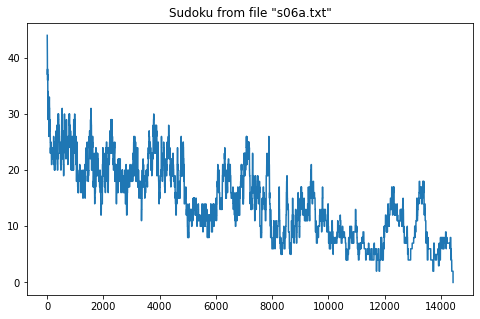

         Solved          
-------------------------
| 2 3 8 | 4 6 7 | 9 1 5 |
| 4 1 5 | 2 9 3 | 6 7 8 |
| 7 9 6 | 8 5 1 | 2 3 4 |
-------------------------
| 9 7 3 | 5 4 8 | 1 6 2 |
| 6 2 4 | 1 3 9 | 8 5 7 |
| 8 5 1 | 7 2 6 | 4 9 3 |
-------------------------
| 5 8 7 | 9 1 2 | 3 4 6 |
| 1 6 2 | 3 7 4 | 5 8 9 |
| 3 4 9 | 6 8 5 | 7 2 1 |
-------------------------



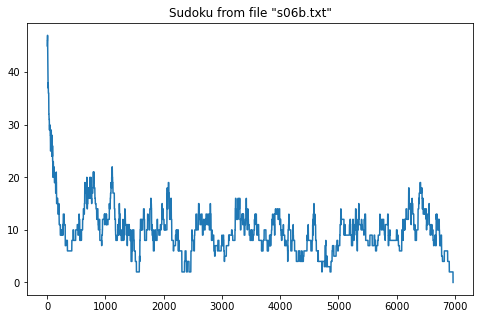

         Solved          
-------------------------
| 3 1 2 | 8 6 5 | 9 4 7 |
| 6 5 7 | 9 3 4 | 1 8 2 |
| 8 9 4 | 1 7 2 | 5 6 3 |
-------------------------
| 2 4 6 | 7 9 1 | 3 5 8 |
| 1 3 5 | 4 8 6 | 2 7 9 |
| 7 8 9 | 5 2 3 | 4 1 6 |
-------------------------
| 4 7 8 | 3 1 9 | 6 2 5 |
| 5 2 3 | 6 4 8 | 7 9 1 |
| 9 6 1 | 2 5 7 | 8 3 4 |
-------------------------



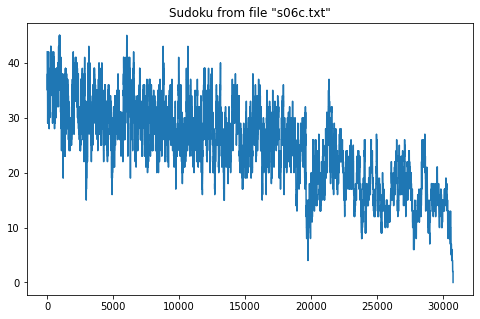

         Solved          
-------------------------
| 2 7 1 | 8 3 9 | 5 4 6 |
| 4 6 9 | 2 7 5 | 8 1 3 |
| 8 3 5 | 1 6 4 | 7 9 2 |
-------------------------
| 3 4 2 | 9 1 7 | 6 5 8 |
| 6 5 8 | 4 2 3 | 9 7 1 |
| 9 1 7 | 5 8 6 | 2 3 4 |
-------------------------
| 1 2 3 | 7 5 8 | 4 6 9 |
| 7 9 6 | 3 4 2 | 1 8 5 |
| 5 8 4 | 6 9 1 | 3 2 7 |
-------------------------



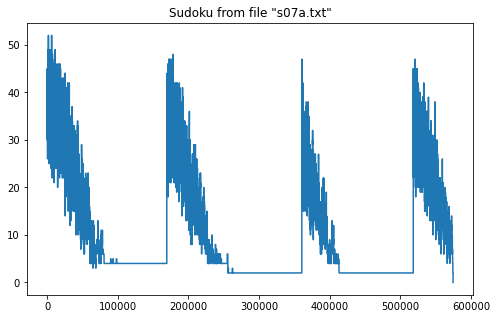

         Solved          
-------------------------
| 3 6 2 | 7 9 4 | 1 8 5 |
| 5 1 8 | 6 2 3 | 7 9 4 |
| 4 9 7 | 1 8 5 | 2 3 6 |
-------------------------
| 8 5 9 | 4 6 2 | 3 7 1 |
| 1 4 6 | 8 3 7 | 5 2 9 |
| 2 7 3 | 5 1 9 | 4 6 8 |
-------------------------
| 9 3 5 | 2 4 8 | 6 1 7 |
| 7 8 1 | 3 5 6 | 9 4 2 |
| 6 2 4 | 9 7 1 | 8 5 3 |
-------------------------



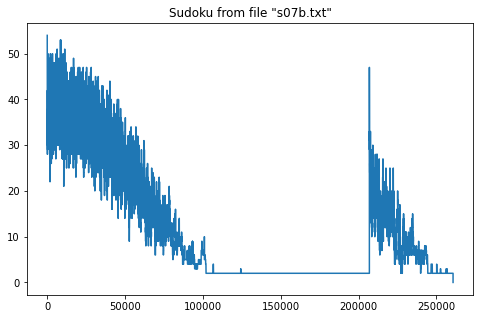

         Solved          
-------------------------
| 6 7 2 | 8 4 1 | 3 5 9 |
| 4 9 5 | 7 6 3 | 2 8 1 |
| 3 8 1 | 9 5 2 | 6 7 4 |
-------------------------
| 8 1 3 | 6 9 7 | 4 2 5 |
| 5 2 6 | 3 1 4 | 7 9 8 |
| 7 4 9 | 5 2 8 | 1 3 6 |
-------------------------
| 2 6 7 | 1 8 9 | 5 4 3 |
| 1 3 8 | 4 7 5 | 9 6 2 |
| 9 5 4 | 2 3 6 | 8 1 7 |
-------------------------



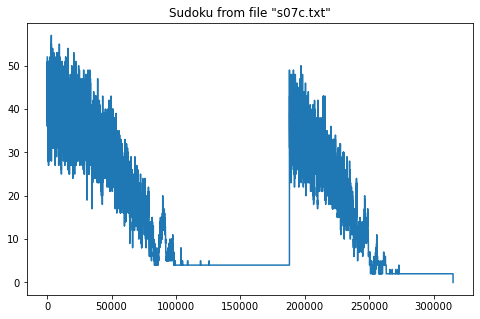

         Solved          
-------------------------
| 9 8 7 | 5 2 1 | 4 6 3 |
| 4 6 3 | 9 7 8 | 5 1 2 |
| 2 1 5 | 3 4 6 | 9 8 7 |
-------------------------
| 3 4 1 | 7 6 9 | 2 5 8 |
| 7 2 6 | 8 3 5 | 1 9 4 |
| 5 9 8 | 2 1 4 | 3 7 6 |
-------------------------
| 1 3 2 | 6 5 7 | 8 4 9 |
| 8 7 4 | 1 9 2 | 6 3 5 |
| 6 5 9 | 4 8 3 | 7 2 1 |
-------------------------



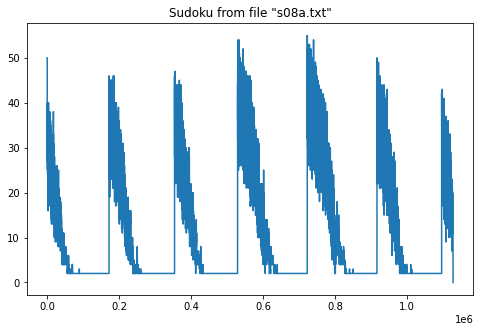

         Solved          
-------------------------
| 6 7 5 | 9 4 8 | 2 1 3 |
| 3 2 8 | 1 6 5 | 9 7 4 |
| 1 4 9 | 7 3 2 | 5 6 8 |
-------------------------
| 2 9 1 | 3 5 7 | 4 8 6 |
| 4 8 6 | 2 9 1 | 7 3 5 |
| 5 3 7 | 6 8 4 | 1 2 9 |
-------------------------
| 8 1 4 | 5 2 3 | 6 9 7 |
| 9 5 2 | 8 7 6 | 3 4 1 |
| 7 6 3 | 4 1 9 | 8 5 2 |
-------------------------



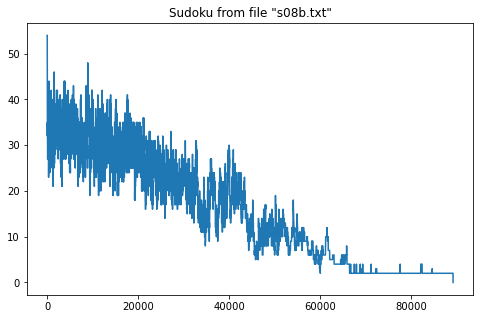

         Solved          
-------------------------
| 3 8 4 | 7 2 9 | 1 5 6 |
| 1 2 5 | 3 4 6 | 9 7 8 |
| 7 9 6 | 5 8 1 | 4 2 3 |
-------------------------
| 4 1 7 | 6 9 3 | 5 8 2 |
| 8 6 2 | 4 1 5 | 3 9 7 |
| 9 5 3 | 8 7 2 | 6 1 4 |
-------------------------
| 2 3 1 | 9 6 7 | 8 4 5 |
| 6 4 9 | 2 5 8 | 7 3 1 |
| 5 7 8 | 1 3 4 | 2 6 9 |
-------------------------



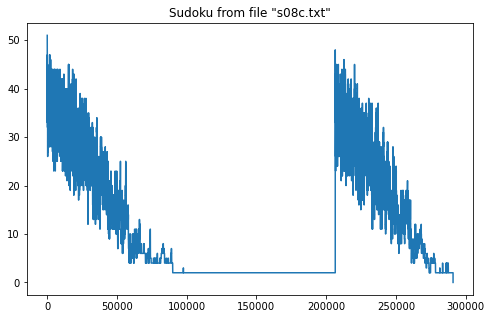

         Solved          
-------------------------
| 9 5 3 | 7 8 1 | 6 2 4 |
| 6 2 7 | 3 9 4 | 5 1 8 |
| 8 4 1 | 2 5 6 | 9 3 7 |
-------------------------
| 3 6 4 | 5 1 8 | 2 7 9 |
| 2 9 5 | 6 3 7 | 8 4 1 |
| 1 7 8 | 9 4 2 | 3 5 6 |
-------------------------
| 4 1 9 | 8 2 3 | 7 6 5 |
| 5 3 6 | 4 7 9 | 1 8 2 |
| 7 8 2 | 1 6 5 | 4 9 3 |
-------------------------



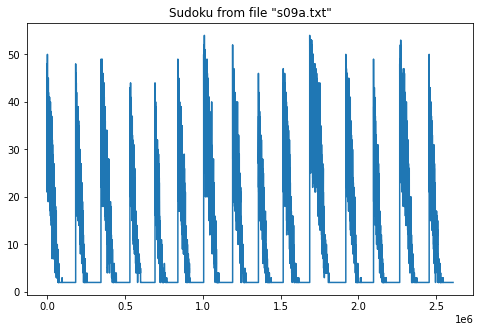

        Error = 2        
-------------------------
| 1 9 7 | 3 8 4 | 5 6 2 |
| 8 5 2 | 1 7 6 | 9 3 4 |
| 4 6 3 | 9 5 2 | 8 7 1 |
-------------------------
| 5 7 9 | 8 1 3 | 2 4 6 |
| 6 3 4 | 2 9 7 | 1 5 8 |
| 2 8 1 | 4 6 5 | 7 9 3 |
-------------------------
| 3 2 5 | 8 4 9 | 6 1 7 |
| 7 4 6 | 5 2 1 | 3 8 9 |
| 9 1 8 | 7 3 6 | 4 2 5 |
-------------------------



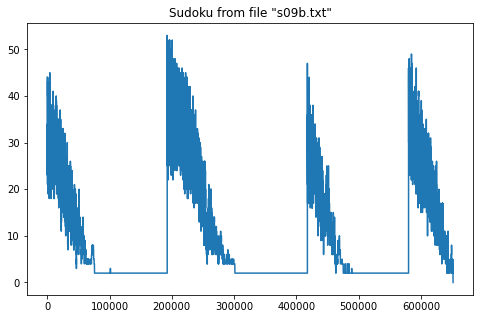

         Solved          
-------------------------
| 1 4 9 | 7 2 5 | 6 8 3 |
| 8 2 6 | 4 3 1 | 9 5 7 |
| 5 7 3 | 8 6 9 | 1 4 2 |
-------------------------
| 3 8 5 | 1 9 7 | 2 6 4 |
| 9 1 4 | 2 5 6 | 3 7 8 |
| 2 6 7 | 3 8 4 | 5 9 1 |
-------------------------
| 7 5 8 | 9 1 2 | 4 3 6 |
| 4 9 2 | 6 7 3 | 8 1 5 |
| 6 3 1 | 5 4 8 | 7 2 9 |
-------------------------



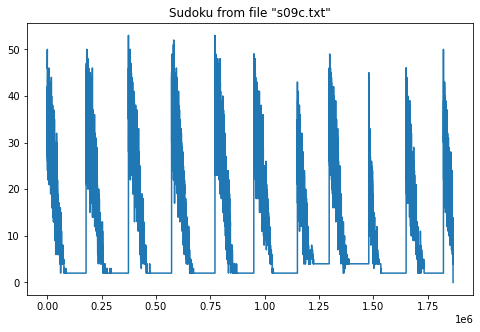

         Solved          
-------------------------
| 9 2 7 | 1 3 6 | 8 4 5 |
| 6 4 1 | 9 8 5 | 7 2 3 |
| 8 3 5 | 4 7 2 | 6 9 1 |
-------------------------
| 3 6 4 | 7 5 9 | 1 8 2 |
| 2 5 8 | 6 1 4 | 3 7 9 |
| 1 7 9 | 3 2 8 | 5 6 4 |
-------------------------
| 4 9 3 | 5 6 7 | 2 1 8 |
| 5 8 6 | 2 9 1 | 4 3 7 |
| 7 1 2 | 8 4 3 | 9 5 6 |
-------------------------



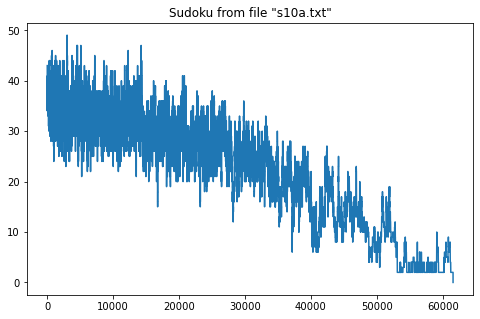

         Solved          
-------------------------
| 9 7 2 | 8 6 3 | 5 4 1 |
| 6 1 8 | 7 4 5 | 9 2 3 |
| 4 5 3 | 2 9 1 | 6 8 7 |
-------------------------
| 5 4 9 | 1 2 8 | 7 3 6 |
| 8 2 1 | 6 3 7 | 4 5 9 |
| 7 3 6 | 4 5 9 | 2 1 8 |
-------------------------
| 2 9 5 | 3 8 6 | 1 7 4 |
| 1 8 4 | 9 7 2 | 3 6 5 |
| 3 6 7 | 5 1 4 | 8 9 2 |
-------------------------



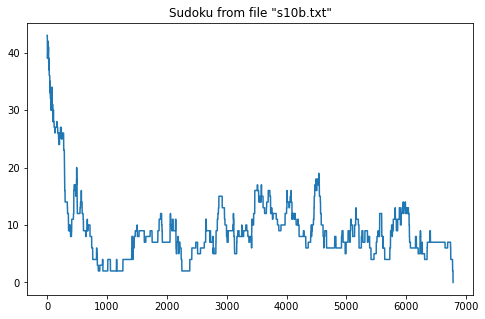

         Solved          
-------------------------
| 8 5 2 | 7 1 6 | 9 4 3 |
| 1 9 7 | 8 4 3 | 6 5 2 |
| 4 6 3 | 9 2 5 | 1 8 7 |
-------------------------
| 2 7 8 | 6 3 4 | 5 9 1 |
| 6 4 5 | 1 7 9 | 3 2 8 |
| 9 3 1 | 5 8 2 | 4 7 6 |
-------------------------
| 7 8 6 | 4 9 1 | 2 3 5 |
| 3 1 4 | 2 5 8 | 7 6 9 |
| 5 2 9 | 3 6 7 | 8 1 4 |
-------------------------



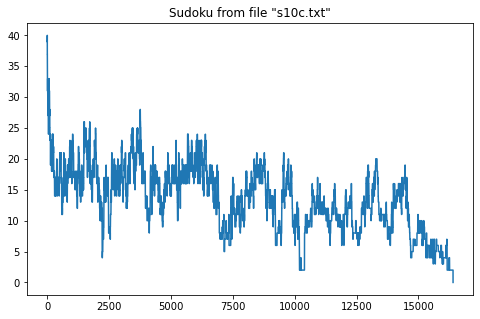

         Solved          
-------------------------
| 1 9 3 | 6 7 2 | 4 8 5 |
| 4 6 2 | 3 5 8 | 9 7 1 |
| 7 8 5 | 9 1 4 | 6 2 3 |
-------------------------
| 5 3 8 | 2 9 6 | 7 1 4 |
| 6 7 4 | 1 3 5 | 2 9 8 |
| 2 1 9 | 4 8 7 | 3 5 6 |
-------------------------
| 8 2 6 | 7 4 1 | 5 3 9 |
| 9 4 1 | 5 2 3 | 8 6 7 |
| 3 5 7 | 8 6 9 | 1 4 2 |
-------------------------



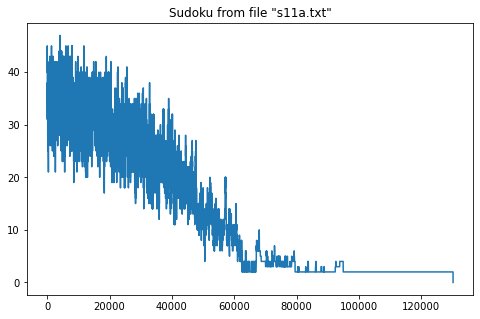

         Solved          
-------------------------
| 3 4 5 | 8 7 1 | 2 6 9 |
| 2 7 9 | 6 5 3 | 1 8 4 |
| 8 6 1 | 4 2 9 | 5 3 7 |
-------------------------
| 1 9 7 | 3 4 6 | 8 5 2 |
| 4 5 2 | 7 1 8 | 3 9 6 |
| 6 8 3 | 5 9 2 | 7 4 1 |
-------------------------
| 7 3 8 | 2 6 4 | 9 1 5 |
| 5 1 6 | 9 3 7 | 4 2 8 |
| 9 2 4 | 1 8 5 | 6 7 3 |
-------------------------



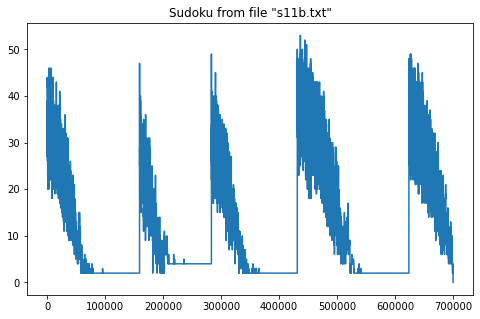

         Solved          
-------------------------
| 1 3 2 | 6 4 9 | 7 8 5 |
| 7 5 8 | 2 1 3 | 6 4 9 |
| 9 6 4 | 7 8 5 | 1 2 3 |
-------------------------
| 5 4 3 | 8 9 7 | 2 1 6 |
| 2 7 6 | 5 3 1 | 8 9 4 |
| 8 9 1 | 4 2 6 | 5 3 7 |
-------------------------
| 6 1 9 | 3 7 8 | 4 5 2 |
| 3 2 7 | 1 5 4 | 9 6 8 |
| 4 8 5 | 9 6 2 | 3 7 1 |
-------------------------



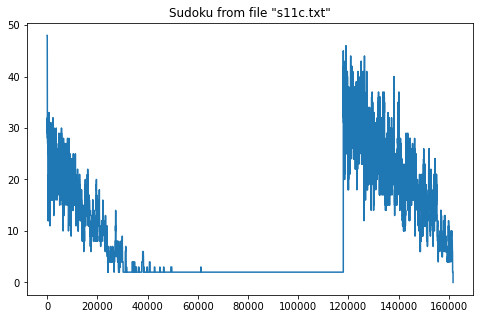

         Solved          
-------------------------
| 7 8 5 | 9 2 4 | 6 3 1 |
| 9 2 4 | 1 6 3 | 5 8 7 |
| 6 3 1 | 5 7 8 | 2 4 9 |
-------------------------
| 8 4 3 | 6 9 2 | 7 1 5 |
| 1 5 9 | 3 8 7 | 4 2 6 |
| 2 7 6 | 4 5 1 | 3 9 8 |
-------------------------
| 4 6 8 | 7 3 9 | 1 5 2 |
| 3 9 7 | 2 1 5 | 8 6 4 |
| 5 1 2 | 8 4 6 | 9 7 3 |
-------------------------



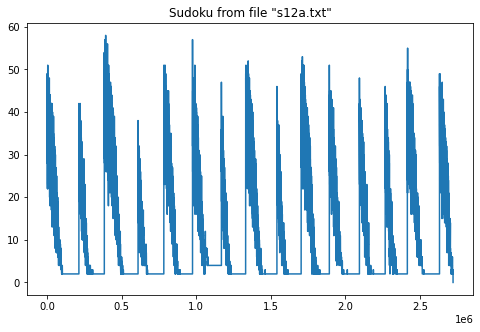

         Solved          
-------------------------
| 2 9 4 | 8 6 3 | 5 1 7 |
| 7 1 5 | 4 2 9 | 6 3 8 |
| 8 6 3 | 7 5 1 | 4 9 2 |
-------------------------
| 1 5 2 | 9 4 7 | 8 6 3 |
| 4 7 9 | 3 8 6 | 2 5 1 |
| 6 3 8 | 5 1 2 | 9 7 4 |
-------------------------
| 9 8 6 | 1 3 4 | 7 2 5 |
| 5 2 1 | 6 7 8 | 3 4 9 |
| 3 4 7 | 2 9 5 | 1 8 6 |
-------------------------



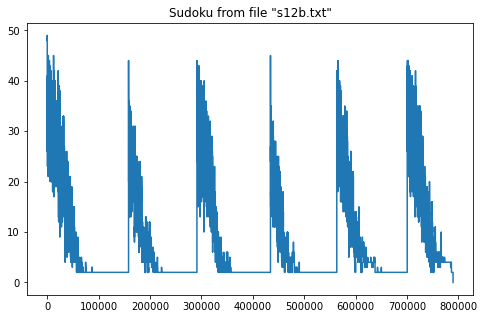

         Solved          
-------------------------
| 3 8 4 | 5 6 7 | 9 2 1 |
| 1 2 6 | 4 3 9 | 7 8 5 |
| 7 5 9 | 8 2 1 | 3 4 6 |
-------------------------
| 5 6 3 | 7 9 8 | 2 1 4 |
| 8 4 7 | 3 1 2 | 6 5 9 |
| 9 1 2 | 6 4 5 | 8 7 3 |
-------------------------
| 2 3 1 | 9 7 4 | 5 6 8 |
| 4 9 5 | 2 8 6 | 1 3 7 |
| 6 7 8 | 1 5 3 | 4 9 2 |
-------------------------



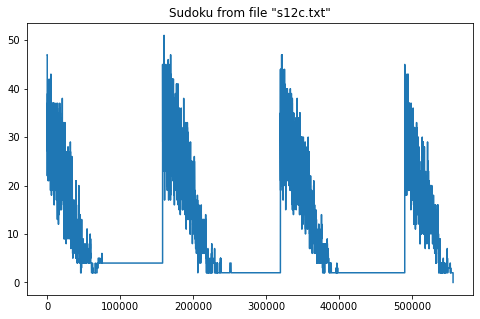

         Solved          
-------------------------
| 1 5 9 | 7 4 3 | 8 6 2 |
| 2 7 6 | 5 8 9 | 4 3 1 |
| 3 4 8 | 6 1 2 | 7 5 9 |
-------------------------
| 6 2 4 | 9 7 8 | 3 1 5 |
| 9 1 7 | 2 3 5 | 6 8 4 |
| 5 8 3 | 1 6 4 | 2 9 7 |
-------------------------
| 4 3 5 | 8 2 1 | 9 7 6 |
| 8 6 1 | 4 9 7 | 5 2 3 |
| 7 9 2 | 3 5 6 | 1 4 8 |
-------------------------



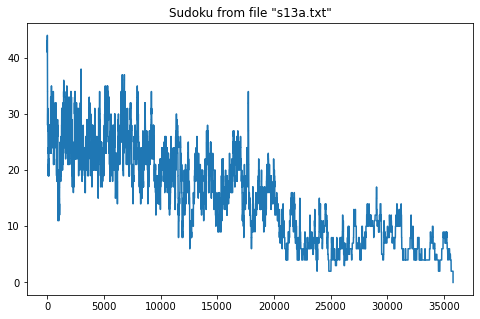

         Solved          
-------------------------
| 7 6 3 | 1 2 8 | 4 5 9 |
| 9 2 4 | 5 6 7 | 8 3 1 |
| 8 5 1 | 9 3 4 | 2 7 6 |
-------------------------
| 4 1 8 | 2 9 5 | 3 6 7 |
| 2 7 5 | 6 4 3 | 1 9 8 |
| 6 3 9 | 7 8 1 | 5 4 2 |
-------------------------
| 3 4 2 | 8 7 6 | 9 1 5 |
| 1 8 6 | 3 5 9 | 7 2 4 |
| 5 9 7 | 4 1 2 | 6 8 3 |
-------------------------



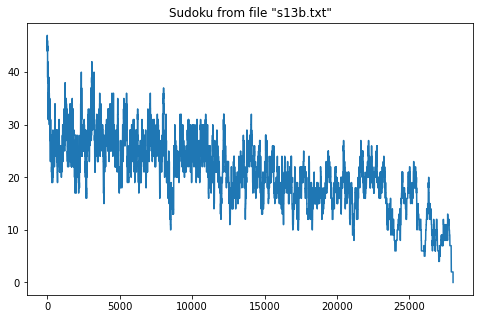

         Solved          
-------------------------
| 1 7 3 | 8 5 9 | 6 2 4 |
| 2 9 8 | 7 4 6 | 1 5 3 |
| 4 5 6 | 2 3 1 | 9 7 8 |
-------------------------
| 3 1 7 | 4 2 8 | 5 6 9 |
| 8 4 9 | 1 6 5 | 7 3 2 |
| 6 2 5 | 9 7 3 | 8 4 1 |
-------------------------
| 5 8 2 | 6 9 4 | 3 1 7 |
| 9 3 4 | 5 1 7 | 2 8 6 |
| 7 6 1 | 3 8 2 | 4 9 5 |
-------------------------



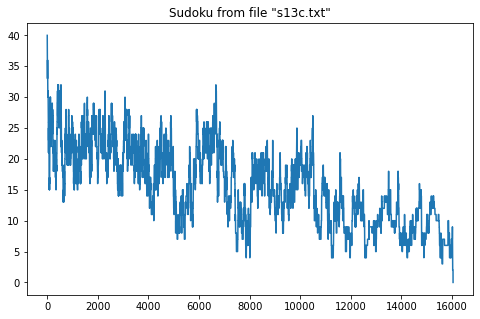

         Solved          
-------------------------
| 9 4 7 | 5 3 1 | 8 2 6 |
| 6 3 5 | 8 2 4 | 9 1 7 |
| 2 1 8 | 7 9 6 | 4 5 3 |
-------------------------
| 5 6 3 | 1 8 7 | 2 4 9 |
| 8 9 4 | 6 5 2 | 3 7 1 |
| 1 7 2 | 3 4 9 | 5 6 8 |
-------------------------
| 3 8 6 | 4 7 5 | 1 9 2 |
| 7 5 9 | 2 1 8 | 6 3 4 |
| 4 2 1 | 9 6 3 | 7 8 5 |
-------------------------



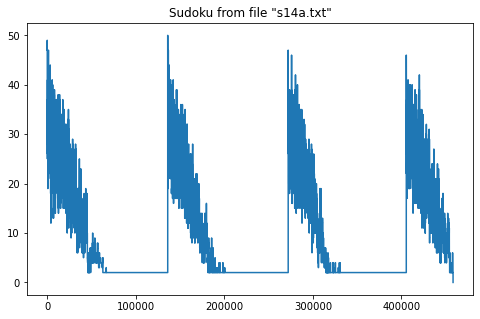

         Solved          
-------------------------
| 8 7 3 | 9 6 1 | 4 2 5 |
| 6 2 4 | 7 5 3 | 9 1 8 |
| 9 5 1 | 2 4 8 | 3 7 6 |
-------------------------
| 5 1 8 | 6 9 4 | 2 3 7 |
| 2 6 9 | 1 3 7 | 5 8 4 |
| 4 3 7 | 5 8 2 | 6 9 1 |
-------------------------
| 3 8 2 | 4 7 5 | 1 6 9 |
| 7 9 5 | 3 1 6 | 8 4 2 |
| 1 4 6 | 8 2 9 | 7 5 3 |
-------------------------



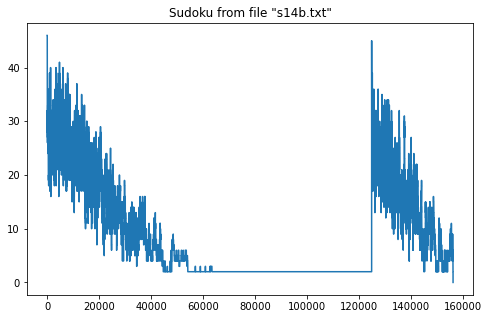

         Solved          
-------------------------
| 8 4 6 | 9 1 3 | 7 5 2 |
| 3 9 5 | 7 4 2 | 8 1 6 |
| 1 7 2 | 6 5 8 | 9 3 4 |
-------------------------
| 7 5 4 | 2 8 9 | 1 6 3 |
| 9 8 3 | 1 6 5 | 2 4 7 |
| 6 2 1 | 4 3 7 | 5 8 9 |
-------------------------
| 2 3 8 | 5 9 4 | 6 7 1 |
| 4 1 9 | 8 7 6 | 3 2 5 |
| 5 6 7 | 3 2 1 | 4 9 8 |
-------------------------



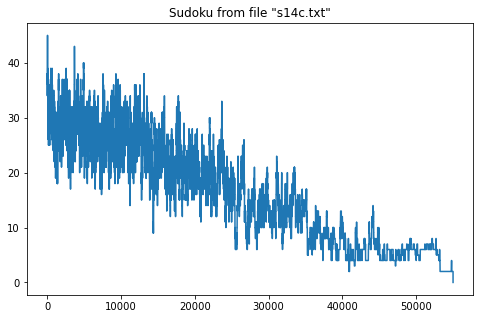

         Solved          
-------------------------
| 1 7 2 | 8 4 3 | 6 5 9 |
| 9 5 8 | 6 2 7 | 4 3 1 |
| 6 4 3 | 5 1 9 | 7 2 8 |
-------------------------
| 8 6 4 | 3 5 2 | 1 9 7 |
| 5 3 7 | 9 6 1 | 2 8 4 |
| 2 1 9 | 7 8 4 | 3 6 5 |
-------------------------
| 4 9 1 | 2 3 8 | 5 7 6 |
| 3 8 5 | 1 7 6 | 9 4 2 |
| 7 2 6 | 4 9 5 | 8 1 3 |
-------------------------



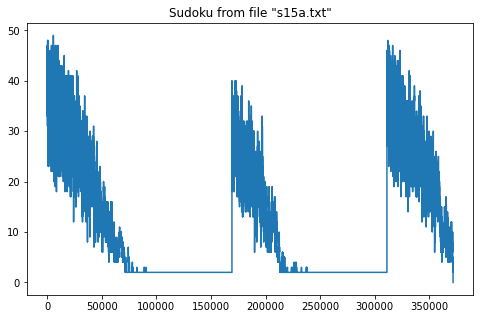

         Solved          
-------------------------
| 7 9 2 | 5 6 8 | 1 4 3 |
| 4 5 3 | 2 1 9 | 8 6 7 |
| 8 6 1 | 3 7 4 | 9 5 2 |
-------------------------
| 6 2 5 | 8 9 3 | 7 1 4 |
| 3 7 9 | 1 4 2 | 6 8 5 |
| 1 4 8 | 7 5 6 | 2 3 9 |
-------------------------
| 2 8 4 | 9 3 1 | 5 7 6 |
| 9 3 7 | 6 8 5 | 4 2 1 |
| 5 1 6 | 4 2 7 | 3 9 8 |
-------------------------



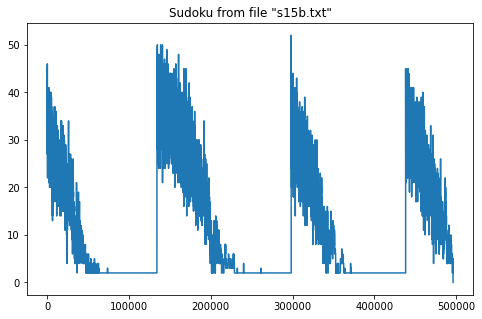

         Solved          
-------------------------
| 6 7 3 | 8 1 5 | 4 2 9 |
| 1 4 5 | 2 7 9 | 8 3 6 |
| 9 8 2 | 6 3 4 | 5 7 1 |
-------------------------
| 4 1 9 | 5 6 3 | 7 8 2 |
| 3 6 7 | 4 2 8 | 9 1 5 |
| 2 5 8 | 7 9 1 | 3 6 4 |
-------------------------
| 5 2 1 | 9 8 7 | 6 4 3 |
| 8 3 4 | 1 5 6 | 2 9 7 |
| 7 9 6 | 3 4 2 | 1 5 8 |
-------------------------



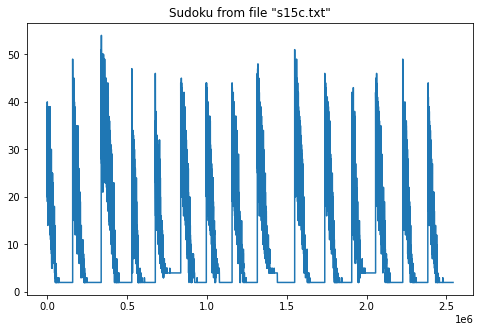

        Error = 2        
-------------------------
| 7 9 2 | 8 1 3 | 5 4 3 |
| 4 5 3 | 2 9 7 | 1 6 8 |
| 8 6 1 | 5 6 4 | 7 9 2 |
-------------------------
| 6 2 5 | 9 7 8 | 3 1 4 |
| 3 7 9 | 1 4 2 | 6 8 5 |
| 1 4 8 | 3 5 6 | 2 7 9 |
-------------------------
| 2 8 4 | 7 3 1 | 9 5 6 |
| 9 3 7 | 6 8 5 | 4 2 1 |
| 5 1 6 | 4 2 9 | 8 3 7 |
-------------------------



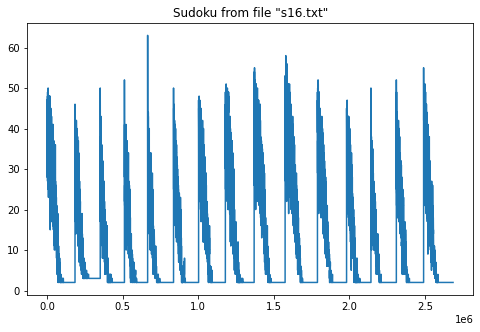

        Error = 2        
-------------------------
| 1 8 6 | 4 5 7 | 2 9 3 |
| 5 3 4 | 1 2 9 | 7 6 8 |
| 7 2 9 | 6 3 8 | 5 4 1 |
-------------------------
| 4 7 5 | 3 6 1 | 9 8 6 |
| 2 1 3 | 9 8 5 | 4 7 2 |
| 6 9 8 | 2 7 4 | 1 3 5 |
-------------------------
| 3 5 2 | 7 4 6 | 8 1 9 |
| 8 4 1 | 5 9 3 | 6 2 7 |
| 9 6 7 | 8 1 2 | 3 5 4 |
-------------------------


Sum of errors = 6, solved 93%



In [11]:
errors_sum = 0
solved = 0
results = np.zeros((len(test_cases), 2))

for i, test in enumerate(test_cases):
    solution, values = multiple_anneal('sudoku/' + test)
    results[i, :] = [empty_cells('sudoku/' + test), len(values)]
    error = energy(solution)

    plt.figure(figsize=(8, 5))
    plt.plot(values)
    plt.title(f"Sudoku from file \"{test}\"")
    plt.show()
    print_sudoku(solution, error)

    errors_sum += error
    if error == 0:
        solved += 1

print(f"\nSum of errors = {errors_sum}, solved {solved / len(test_cases):.0%}\n")

Moja implementacja metody symulowanego wyżarzania pozwoliła na rozwiązanie 93% przygotowanych plansz - jedynie trzy nie zostaly rozwiązane, a popełniony błąd na każdej z nich wynosił zaledwie 2.

Poniżej prezentuję zależność liczby potrzebnych iteracji algorytmu od ilości pustych miejsc w pliku z planszą Sudoku.

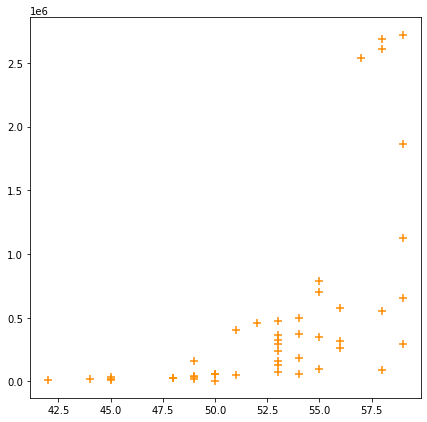

In [12]:
plt.figure(figsize=(7, 7))
plt.scatter(results[:, 0], results[:, 1], marker='+', c='darkorange', s=50)
plt.show()

## Wnioski

 - Dobór parametrów w metodzie symulowanego wyżarzania ma kluczowe znaczenie. Jednym z takich parametrów jest temperatura początkowa - jak wspomina Rhyd Lewis, musi być ona tak dobrana, aby dopucić około 80% ruchów. Obliczanie jej, jako odchylenie standardowe kilku losowych stanów, wydaje się być dobrą metodą.
 
 - Drugim parametrem związanym z temperaturą, jest szybkość jej spadku. Zastosowałem w tym programie wykładniczy spadek temperatury z mnożnikiem 0.975 dobranym eksperymentalnie. Zbyt wolny spadek mógłby spowodować chaotyczne zachowanie funkcji kosztu oraz powolne znajdowanie minimum, natomiast zbyt szybki spadek grozi pominięciem minimum globalnego na rzecz pewnego minimum lokalnego.
 
 - Zastosowanie homogenicznego symulowanego wyżarzania dało dobre rezultaty - dzięki temu program przeszukuje wiele stanów z taką samą temperaturą i może lepiej wyszukiwać minima.
 
 - Kluczowym parametrem w homogenicznym wyżarzaniu jest ilość kroków pomiędzy spadkami temperatury. Idąc za radą Rhyd'a Lewis'a, uzależniłem ten parametr od kwadratu liczby pustych miejsc na planszy, jednak zmniejszyłem go trzykrotnie ze względu na długi czas działania metody. Zbyt duża wartość tego parametru niepotrzebnie zwiększa ilość iteracji, natomiast zbyt mała mogłaby prowadzić do zbyt szybkiego obniżania temperatury, a tym samym ominięcia globalnego minimum.
 
 - Zaimplementowanie restartowania wyżarzania było bardzo ważne i pozwoliło na rozwiązanie znacznie większej ilości Sudoku. Dość często zdarza się, że algorytm "utknie" w lokalnym minimum i wówczas tylko ponowne losowanie oraz przeprowadzenie procedury może naprawić ten błąd. Ważnym parametrem jest tutaj ilość iteracji bez poprawy, która spowoduje, że algorytm zrestartuje się. Ustawiłem tą wartość na 100 cykli - jest to dość dużo i powodowało czasami niepotrzebne wydłużenie działania algorytmu, jednak chciałem mieć pewność, że przed restartem algorytm "zrobi wszystko", aby jeszcze poprawić swój wynik. Podobnie, dopuszczenie 15 restartów sprawiło, że przy niektórych planszach program działał dość długo, ale taka duża liczba pomogła rozwiązać cześć trudnych Sudoku.

 - Widać wyraźną zależność pomiędzy liczbą iteracji, a ilością pustych miejsc na planszy. W ogólności można powiedzieć, że im więcej pustych miejsc, tym więcej iteracji. Możemy jednak zauważyć, że od pewnej wartości (~57), czas działania metody znacznie rośnie. Wynika to prawdopodobnie ze znacznie większej złożoności problemu z każdym kolejnym pustym polem.